In [1]:
import os
import gc

os.chdir('../../')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import json

# For CatBoost
from catboost import CatBoostRegressor

# For MAPIE Conformal
from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieQuantileRegressor, MapieRegressor

from global_code.util import plot_prediction_intervals

# For metrics
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")


d:\Files\repositorios\modern-ml\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data week_2/data/processed/sg-resale-flat-prices-engineered.parquet
df = pd.read_parquet('week_2/data/processed/sg-resale-flat-prices-engineered.parquet')

# Load features list
with open('week_2/data/processed/features_list.json', 'r') as f:
    features_list = json.load(f)



## Splitting the Data: Train, Validation, and Calibration
We split the dataset by date: 
* Train: up to ~2023-12-31 
* Validation + Calibration: 2024-01-01 to 2024-07-01 
* Then we split the validation/calibration 50/50 in that range.

In [4]:
split_date_train_end = pd.to_datetime("2024-01-01")
split_date_val_cal = pd.to_datetime("2024-07-01")

train_mask = (df['month'] < split_date_train_end)
val_cal_mask = (df['month'] >= split_date_train_end) & (df['month'] < split_date_val_cal)

df_train = df.loc[train_mask].copy()
df_val_cal = df.loc[val_cal_mask].copy()

# Now we split df_val_cal 50/50 with random split

np.random.seed(42)
mask = np.random.rand(len(df_val_cal)) < 0.5
df_val = df_val_cal[mask].copy()
df_cal = df_val_cal[~mask].copy()


print("Training set size:", df_train.shape)
print("Validation set size:", df_val.shape)
print("Calibration set size:", df_cal.shape)

# Features (X) and target (y) - We'll use 'corrected_price' as target
X_train = df_train[features_list].copy()
y_train = df_train['corrected_price'].copy()

X_val = df_val[features_list].copy()
y_val = df_val['resale_price'].copy()

X_cal = df_cal[features_list].copy()
y_cal = df_cal['resale_price'].copy()

Training set size: (104896, 68)
Validation set size: (6119, 68)
Calibration set size: (5991, 68)


## Handle categorical features
CatBoost can handle categorical features directly if we specify them, or we can 
label-encode them. For simplicity, let's just treat them as string for CatBoost.

In [5]:
# Select cat features with dtype category
cat_features = X_train.select_dtypes(include=['category']).columns.tolist()


cat_features_indices = []
for i, col in enumerate(features_list):
    if df[col].dtype == 'object':
        cat_features_indices.append(i)

In [6]:
cat_features

['town', 'flat_type', 'storey_range', 'flat_model']

In [7]:
df[cat_features]

,town,flat_type,storey_range,flat_model
0,ANG MO KIO,3 ROOM,04 TO 06,New Generation
1,SENGKANG,4 ROOM,04 TO 06,Premium Apartment
2,SENGKANG,4 ROOM,16 TO 18,Model A
3,SENGKANG,4 ROOM,07 TO 09,Premium Apartment
4,SENGKANG,4 ROOM,04 TO 06,Model A
...,...,...,...,...
117001,GEYLANG,3 ROOM,07 TO 09,Improved
117002,CLEMENTI,EXECUTIVE,07 TO 09,Apartment
117003,CLEMENTI,4 ROOM,04 TO 06,Model A
117004,HOUGANG,4 ROOM,04 TO 06,New Generation


## Vanilla Model SHAP values and permutation importance

In [8]:
cat_features

['town', 'flat_type', 'storey_range', 'flat_model']

RMSE: 35699.546892563994
MAPE: 4.44319300120153


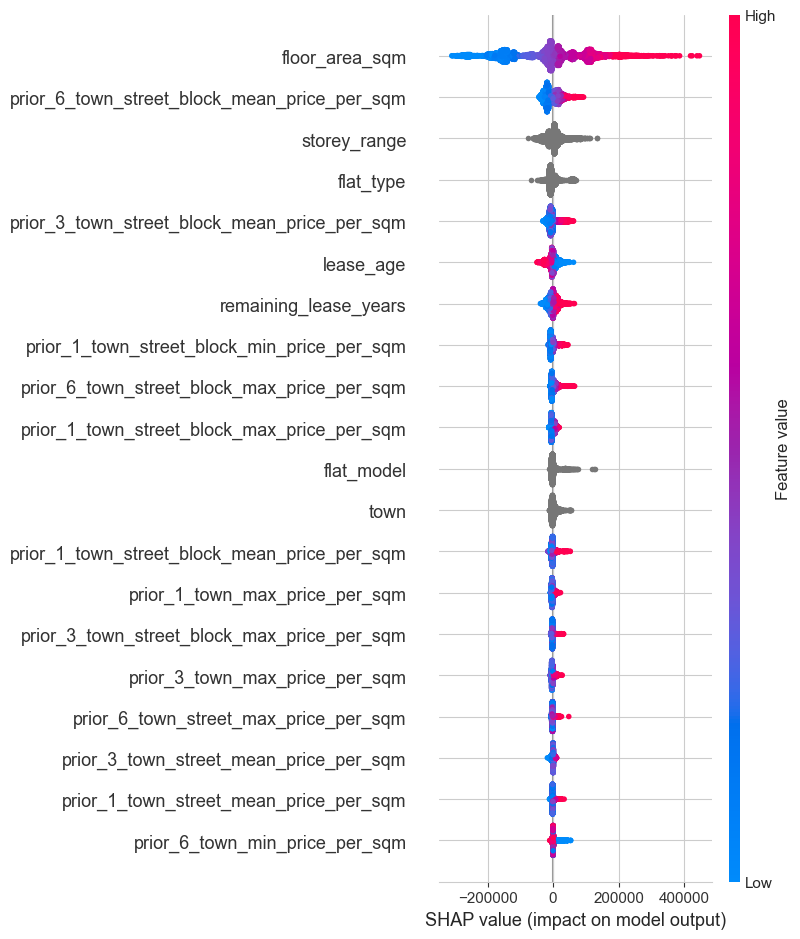

In [9]:
from catboost import CatBoostRegressor, Pool
import shap

# Initialize the CatBoostRegressor
vanilla_model = CatBoostRegressor(
    iterations=500,  # for speed in demonstration
    depth=6,
    verbose=False,  # silence CatBoost prints
    cat_features=cat_features
)

# Fit the model
vanilla_model.fit(X_train, y_train)

# Predict on validation
y_pred = vanilla_model.predict(X_val)

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

# Get SHAP values
explainer = shap.TreeExplainer(vanilla_model)
shap_values = explainer.shap_values(X_val)

# Plot SHAP values
shap.summary_plot(shap_values, X_val, plot_type="dot")

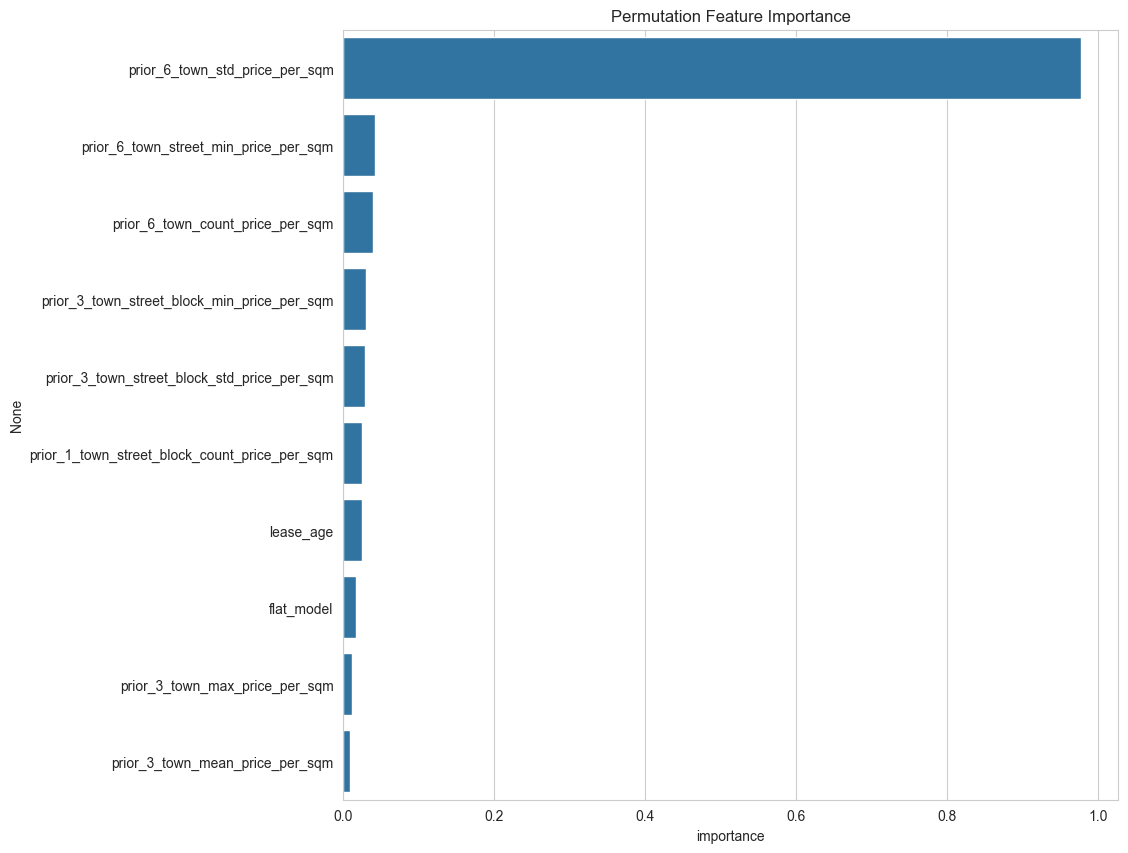

In [10]:
# Plot sklearn permutation feature importance of the vanilla model
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(vanilla_model, X_val, y_val, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

# Build dataframe with importances, variables as a col named features and importances as col named importance
importances = pd.DataFrame(data=perm_importance.importances_mean, index=X_val.columns[sorted_idx], columns=['importance'])
importances = importances.sort_values(by='importance', ascending=False).head(10)

# Plot seaborn bar chart with top 10 importances ordered by importance
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y=importances.index, data=importances, orient='h')
plt.title("Permutation Feature Importance")
plt.show()

## Train and Compare Models with MLflow
Explanation:
We perform four experiments:
  1. MultiQuantile Regression (CatBoost)
  2. Inflation-corrected predictions
  3. Conformalized Quantile Regression (CatBoost + MAPIE)
  4. Inflation-corrected conformal predictions
Each experiment logs metrics (RMSE, coverage, width), parameters, and 
artifacts (plots) to MLflow.

In [20]:
quantile_levels = [0.1, 0.5, 0.9]
quantile_str = str(quantile_levels).replace('[','').replace(']','')

# Common model parameters
params = {
    'iterations': 500,  # for speed in demonstration
    'depth': 6,
    'verbose': False  # silence CatBoost prints
}

## Experiments

In [21]:
def plot_prediction_vs_actual(run_name, y_val, median, lower_bound, upper_bound):
    plt.figure(figsize=(10,5))
    result_df = pd.DataFrame({
        "y_val": y_val,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "median_pred": median
    })
    sns.scatterplot(x='median_pred', y='y_val', data=result_df, marker='o', linestyle='', alpha=0.9)
    plt.errorbar(result_df['median_pred'], result_df['y_val'], 
                 yerr=(result_df['upper_bound'] - result_df['lower_bound']), fmt='o', color='blue', alpha=0.7, ecolor='gray', elinewidth=1, capsize=3)
    plt.legend()
    plt.title(run_name)
    plt.xlabel("Predicted Price")
    plt.ylabel("True Price")
    plt.savefig("actua_price_versus_predicted_price.png", bbox_inches='tight')
    mlflow.log_artifact("actua_price_versus_predicted_price.png")
    plt.show()

def log_metrics(run_name, y_val, median, lower_bound, upper_bound):
        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_val, median))
        coverage = regression_coverage_score(y_val, lower_bound, upper_bound)
        width = regression_mean_width_score(lower_bound, upper_bound)

        # Log metrics
        print('Logging metrics to MLflow: ', run_name, ' ....')
        mlflow.log_param("quantile_levels", quantile_levels)
        mlflow.log_metric("rmse", rmse)
        
        mlflow.log_metric("mape", np.mean(np.abs((y_val - median) / y_val)) * 100)
        mlflow.log_metric("mae", np.mean(np.abs(y_val - median)))
        mlflow.log_metric("mdape", np.median(np.abs((y_val - median) / y_val)) * 100)

        mlflow.log_metric("coverage", coverage)
        mlflow.log_metric("interval_width", width)
        
        

        # Print metrics
        print(run_name)
        print("quantile_levels", quantile_levels)
        print("RMSE:", rmse)
        print("MAPE:", np.mean(np.abs((y_val - median) / y_val)) * 100)
        print("MAE:", np.mean(np.abs(y_val - median)))
        print("MDAPE:", np.median(np.abs((y_val - median) / y_val)) * 100)
        print("Coverage:", coverage)
        print("Interval Width:", width)

### Experiment 1: MultiQuantile Regression (CatBoost)

Running: Experiment 1: CatBoost MultiQuantile
Training the model
Logging metrics to MLflow:  Experiment 1: CatBoost MultiQuantile  ....
Experiment 1: CatBoost MultiQuantile
quantile_levels [0.1, 0.5, 0.9]
RMSE: 37503.07172658926
MAPE: 4.4732961036444685
MAE: 26852.497281263975
MDAPE: 3.648096632926814
Coverage: 0.7609086452034646
Interval Width: 80280.37969862873


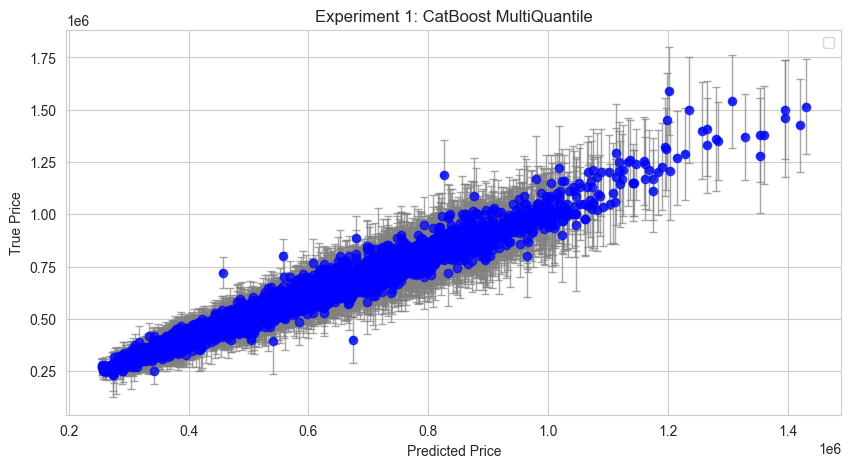

2025/02/24 13:33:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/24 13:33:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
# ------------------------------------------------------------------------------
# Experiment 1: MultiQuantile Regression (CatBoost)
# ------------------------------------------------------------------------------
experiment_id = 'Singapore House Prices'
mlflow.set_experiment(experiment_id)

run_name = "Experiment 1: CatBoost MultiQuantile"
with mlflow.start_run(run_name=run_name) as run:
    print(f'Running: {run_name}')

    # Initialize the CatBoostRegressor for multi-quantile
    model = CatBoostRegressor(
        loss_function=f"MultiQuantile:alpha={quantile_str}",
        cat_features=cat_features,
        **params
    )
    
    # Fit the model
    print('Training the model')
    model.fit(X_train, y_train)

    # Predict on validation
    predictions = model.predict(X_val)
    
    lower_bound = predictions[:, 0] # predictions[:, 0] -> lower 10%
    median_pred = predictions[:, 1] # predictions[:, 1] -> median 50%
    upper_bound = predictions[:, 2] # predictions[:, 2] -> upper 90%
    
    # Log metrics
    log_metrics(run_name, y_val, median_pred, lower_bound, upper_bound)

    # Create a quick plot of the prediction intervals vs. true labels 
    plot_prediction_vs_actual(run_name, y_val, median_pred, lower_bound, upper_bound)
    
    # Log the model
    mlflow.sklearn.log_model(model, "catboost_multiquantile_model")

# Experiment 2: Inflation-Corrected Predictions

Running: Experiment 2: Inflation-Corrected Predictions
Logging metrics to MLflow:  Experiment 2: Inflation-Corrected Predictions  ....
Experiment 2: Inflation-Corrected Predictions
quantile_levels [0.1, 0.5, 0.9]
RMSE: 35690.04024362051
MAPE: 4.414713958787112
MAE: 25775.9146035226
MDAPE: 3.4646015365310237
Coverage: 0.8007844419022716
Interval Width: 83461.47760611455


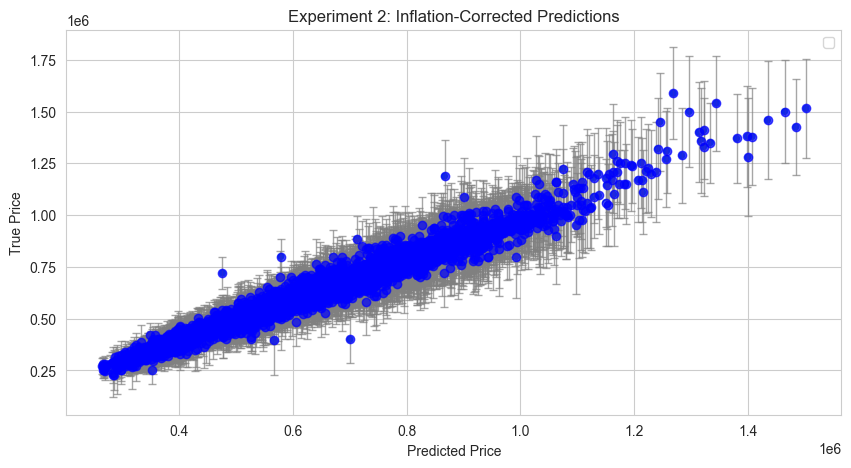

2025/02/24 13:41:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/24 13:41:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [23]:
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# Explanation:
# We take the raw CatBoost multi-quantile predictions from above and further
# adjust them by the predicted_index ratio for the validation period, if needed.
# In many contexts, we might skip a second correction if we've already used
# 'corrected_price' as the target. However, if we wanted to project beyond 
# 2023-12-31, we might scale the predictions by predicted_index ratio.

run_name = "Experiment 2: Inflation-Corrected Predictions"

with mlflow.start_run(run_name="Experiment 2: Inflation-Corrected Predictions") as run:
    # Re-initialize & fit the same model for demonstration
    print(f'Running: {run_name}')
    model2 = CatBoostRegressor(
        loss_function=f"MultiQuantile:alpha={quantile_str}",
        cat_features=cat_features,
        **params
    )
    
    model2.fit(X_train, y_train)
    predictions_raw = model2.predict(X_val)

    # Let's say we want to adjust to some future date's predicted_index. 
    # Because we've used 'corrected_price' as target, it is already corrected 
    # to 2023-12-31. If we want to correct it to a new date, we might do:
    # predicted_future_index / reference_index. 
    # But let's demonstrate the approach anyway.

    ref_index = df_train['index'].iloc[-1]
    scale_factor = (df_val.predicted_index/ref_index)  # ratio of future to 2023-12-31 index
    
    lower_bound_corr = predictions_raw[:, 0] * scale_factor
    median_corr = predictions_raw[:, 1] * scale_factor
    upper_bound_corr = predictions_raw[:, 2] * scale_factor
    
    # Log metrics
    log_metrics(run_name, y_val, median_corr, lower_bound_corr, upper_bound_corr)

    # Create a quick plot of the prediction intervals vs. true labels 
    plot_prediction_vs_actual(run_name, y_val, median_corr, lower_bound_corr, upper_bound_corr)
    
    # Log the model
    mlflow.sklearn.log_model(model2, "catboost_inflation_corrected_model")

###  Experiment 3: Conformalized Quantile Regression (CQR) with MAPIE

Running: Experiment 3: CQR with MAPIE
Logging metrics to MLflow:  Experiment 3: CQR with MAPIE  ....
Experiment 3: CQR with MAPIE
quantile_levels [0.1, 0.5, 0.9]
RMSE: 47296.825253889125
MAPE: 6.218575347897957
MAE: 35511.415731806235
MDAPE: 5.021110895403777
Coverage: 0.8159830037587841
Interval Width: 114336.47020151405


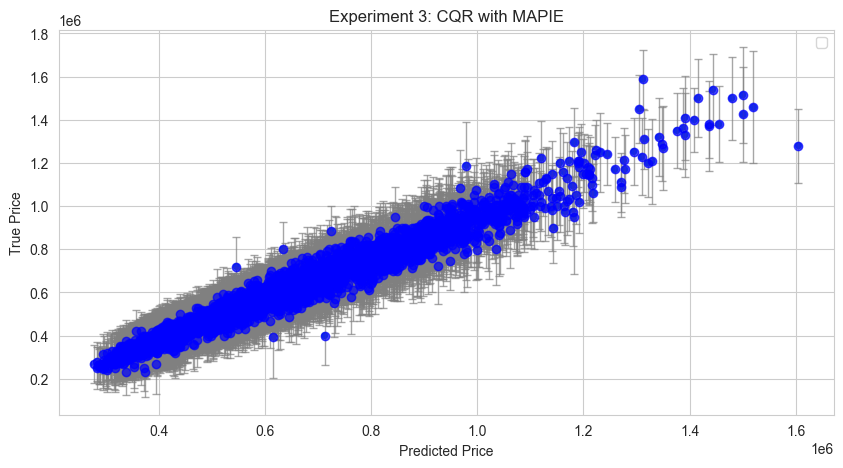

2025/02/24 13:47:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/24 13:47:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
# Explanation:
# Train individual CatBoost models for each alpha, then use MAPIE in 'prefit' mode
# on the calibration set to obtain conformal intervals.
run_name = "Experiment 3: CQR with MAPIE"
with mlflow.start_run(run_name=run_name) as run:
    print(f'Running: {run_name}')
    
    list_estimators_cqr = []
    
    # Train individual models for each alpha
    for alpha_ in quantile_levels:
        estimator_ = CatBoostRegressor(
            loss_function=f"Quantile:alpha={alpha_}",
            cat_features=cat_features,
            **params
        )
        estimator_.fit(X_train, y_train)
        list_estimators_cqr.append(estimator_)
    
    # Now use MapieQuantileRegressor in 'prefit' mode
    mapie_reg = MapieQuantileRegressor(
        list_estimators_cqr,
        cv="prefit", 
        alpha=0.2  # coverage ~ 1 - alpha => 80% coverage intervals
    )
    mapie_reg.fit(X_cal, y_cal)
    
    # Predict on validation
    y_pred_cqr, y_pis_cqr = mapie_reg.predict(X_val)
    lower_bound_cqr = y_pis_cqr[:, 0].reshape(-1,)
    median_cqr = y_pred_cqr  # central estimate
    upper_bound_cqr = y_pis_cqr[:, 1].reshape(-1,)
    

    # Log metrics
    log_metrics(run_name, y_val, median_cqr, lower_bound_cqr, upper_bound_cqr)

    # Create a quick plot of the prediction intervals vs. true labels 
    plot_prediction_vs_actual(run_name, y_val, median_cqr, lower_bound_cqr, upper_bound_cqr)
    
    # Log the final MAPIE object
    mlflow.sklearn.log_model(mapie_reg, "mapie_cqr_model")

### Experiment 4: Inflation-Corrected Conformal Predictions

Running: Experiment 4: CQR with MAPIE Inflation-Corrected
Logging metrics to MLflow:  Experiment 4: CQR with MAPIE Inflation-Corrected  ....
Experiment 4: CQR with MAPIE Inflation-Corrected
quantile_levels [0.1, 0.5, 0.9]
RMSE: 66224.51067898817
MAPE: 9.519684446808913
MAE: 54552.195395038434
MDAPE: 8.627420685072236
Coverage: 0.9313613335512338
Interval Width: 118868.35352103041


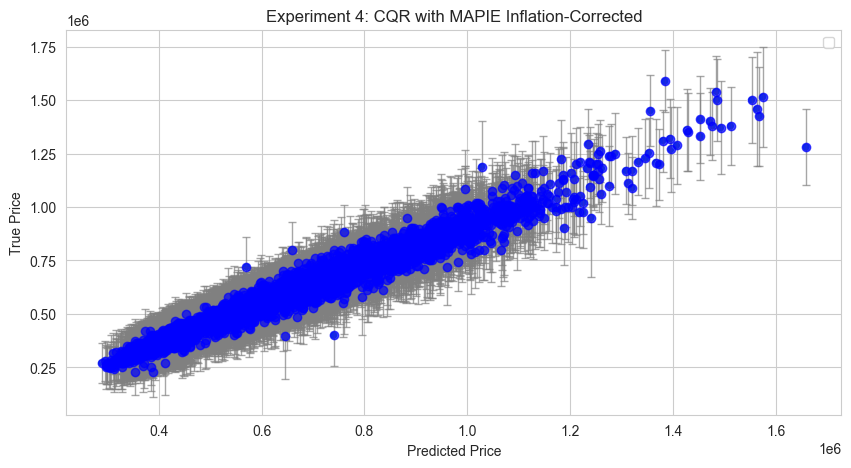

2025/02/24 13:51:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/24 13:51:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
# Explanation:
# Similar to Experiment 2, we apply an additional inflation scaling to the
# conformal intervals if we want to project to a future date beyond 2023-12-31.
run_name = "Experiment 4: CQR with MAPIE Inflation-Corrected"
with mlflow.start_run(run_name=run_name) as run:
    # We'll reuse the same list of CatBoost estimators from above for demonstration,
    # or retrain them quickly.
    print(f'Running: {run_name}')
    
    list_estimators_cqr_corr = []
    for alpha_ in quantile_levels:
        estimator_4 = CatBoostRegressor(
            loss_function=f"Quantile:alpha={alpha_}",
            cat_features=cat_features,
            **params
        )
        estimator_4.fit(X_train, y_train)
        list_estimators_cqr_corr.append(estimator_4)

    # Let's say we want to adjust to some future date's predicted_index. 
    # Because we've used 'corrected_price' as target, it is already corrected 
    # to 2023-12-31. If we want to correct it to a new date, we might do:
    # predicted_future_index / reference_index. 
    # But let's demonstrate the approach anyway.

    ref_index = df_train['index'].iloc[-1]
    scale_factor = (df_val.predicted_index/ref_index)  # ratio of future to 2023-12-31 index

    mapie_reg_corr  = MapieQuantileRegressor(
        list_estimators_cqr_corr ,
        cv="prefit", 
        alpha=0.2
    )
    mapie_reg_corr.fit(X_cal, y_cal)

    y_pred_cqr_corr , y_pis_cqr_corr = mapie_reg_corr.predict(X_val)
    lower_cqr_corr  = y_pis_cqr_corr [:, 0].reshape(-1,) * scale_factor
    median_cqr_corr = y_pred_cqr_corr * scale_factor
    upper_cqr_corr  = y_pis_cqr_corr [:, 1].reshape(-1,) * scale_factor

    # Log metrics
    log_metrics(run_name, y_val, median_cqr_corr, lower_cqr_corr, upper_cqr_corr)

    # Create a quick plot of the prediction intervals vs. true labels 
    plot_prediction_vs_actual(run_name, y_val, median_cqr_corr, lower_cqr_corr, upper_cqr_corr)

    # Log the final MAPIE object
    mlflow.sklearn.log_model(mapie_reg_corr, "mapie_cqr_inflation_corrected_model")

In [ ]:
print("All experiments completed. Check MLflow UI for detailed runs, metrics, and artifacts.")